In [1]:
import numpy as np
import pandas as pd
import sys,os
import pylab
from scipy import stats,signal,io
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
import pickle
import seaborn as sns
sns.set_style('white')

In [316]:
def filter(ephys,freq_range,filt_order = 4,ripple = 0.2,attenuation = 40,filt_type='bandpass',fs=300.):
    
    # design Elliptic filter:

    #[b,a] = signal.ellip(filt_order,ripple,attenuation,[x/(fs/2) for x in freq_range],btype=filt_type)
    
    [b,a] = signal.butter(filt_order,[freq/fs for freq in freq_range],btype=filt_type)
    
    filtered_trace = signal.filtfilt(b,a,ephys,axis=0)
    return filtered_trace


In [2]:
head_data = pd.read_pickle('head_data.pickle')

In [3]:
head_data.keys()

Index([u'Unnamed: 0', u'time', u'bit1', u'bit2', u'ox', u'oy', u'oz', u'ax',
       u'ay', u'az', u'converted_times', u'dx', u'dy', u'dz', u'jerk_x',
       u'jerk_y', u'jerk_z'],
      dtype='object')

In [ ]:
##### integrate acc values in 300-ms time bins 

In [218]:
head_data.converted_times[0:20]

10    7.998138
11    8.011139
12    8.023139
13    8.035139
14    8.048140
15    8.061140
16    8.073140
17    8.085141
18    8.098141
19    8.111141
20    8.124141
21    8.136142
22    8.149142
23    8.162142
24    8.174143
25    8.186143
26    8.199143
27    8.212144
28    8.224144
29    8.236144
Name: converted_times, dtype: float64

In [38]:
edges=np.arange(head_data.converted_times.iloc[0],head_data.converted_times.iloc[-1],0.1)

In [39]:
edges

array([    7.99813849,     8.09813849,     8.19813849, ...,  4521.39813849,
        4521.49813849,  4521.59813849])

In [63]:
edges.shape[0]

45137

In [80]:
def bin_head(head,edges):
    binned_head = np.empty(edges.shape)
   
    for idx,edge in enumerate(edges):
        
        
        if idx < edges.shape[0]-1:
            start = np.where(head_data.converted_times >= edges[idx])[0][0]
            stop = np.where(head_data.converted_times <= edges[idx+1])[0][-1]
        #else:
        #    stop = np.where(head_data.converted_times <= edges[-1])[0][-1]

            #print idx,start,stop+1

            binned_head[idx] = np.trapz(head[start:stop+1])
    return binned_head

In [81]:
binned_ox = bin_head(head_data.ox,edges)

In [95]:
binned_oy = bin_head(head_data.oy,edges)

In [83]:

binned_oz = bin_head(head_data.oz,edges)

In [165]:
binned_ax = bin_head(head_data.ax,edges)

binned_ay = bin_head(head_data.ay,edges)

binned_az = bin_head(head_data.az,edges)

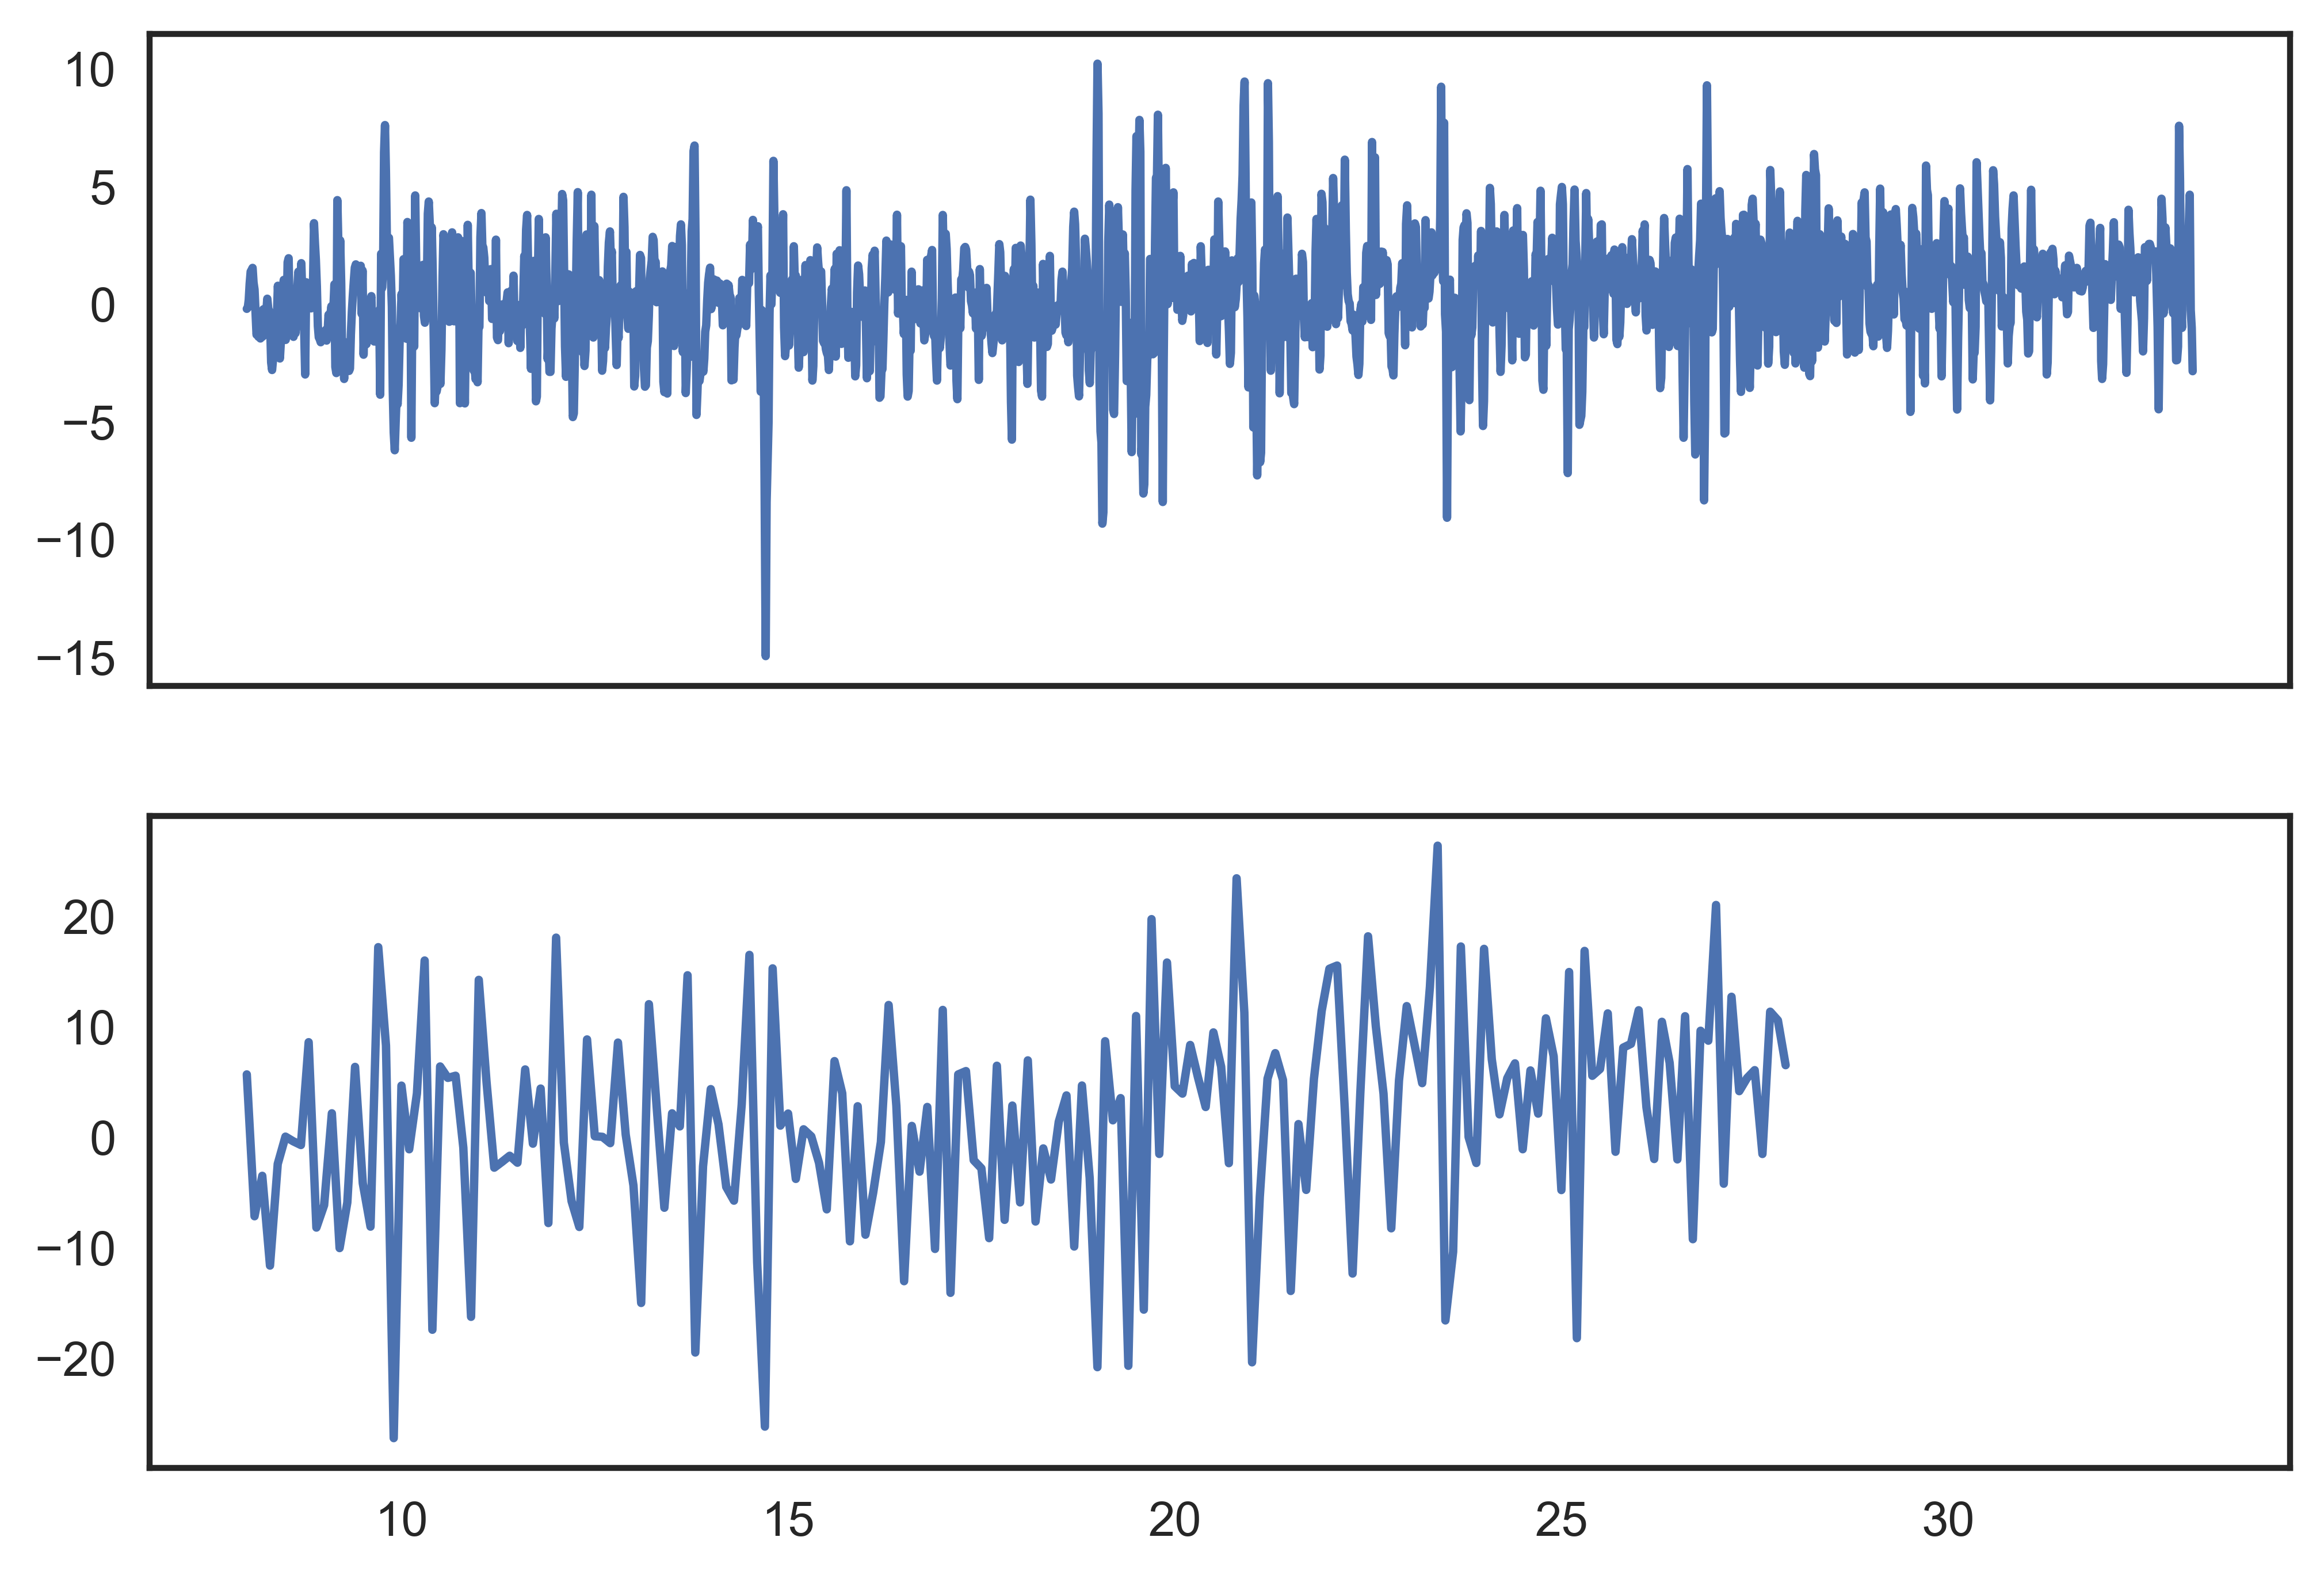

In [166]:
f, axarr = plt.subplots(2, sharex=True,dpi=600)


axarr[0].plot(head_data.converted_times[0:2000],head_data.ax[0:2000])

axarr[1].plot(edges[0:200],binned_ax[0:200])

In [274]:
total_head_angle = np.sqrt(binned_ox**2 + binned_oy**2 + binned_oz**2)

In [273]:
total_head_acc = np.sqrt(binned_ax**2 + binned_ay**2 + binned_az**2)

In [182]:
np.median(total_head_acc)

0.53990739946772359

In [184]:
np.median(total_head_angle)

243.53855813152987

In [185]:
np.mean(binned_oy)

114.38354481910628

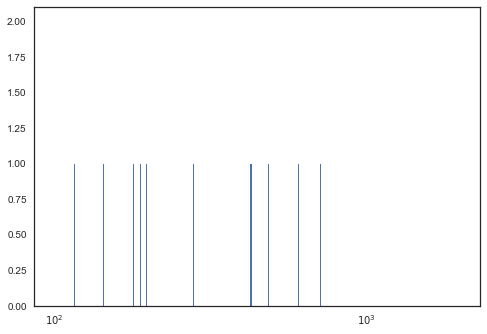

In [275]:
plt.hist(total_head_acc,bins=np.logspace(.1,2.3,1000),range=[100,3500])
plt.gca().set_xscale("log")

(array([  1.10000000e+01,   4.90000000e+01,   1.74000000e+02,
          3.89000000e+02,   7.22000000e+02,   1.18100000e+03,
          1.68800000e+03,   2.12200000e+03,   2.31400000e+03,
          2.30900000e+03,   2.15200000e+03,   1.76700000e+03,
          1.39500000e+03,   1.08600000e+03,   8.10000000e+02,
          6.55000000e+02,   6.14000000e+02,   5.35000000e+02,
          5.06000000e+02,   4.82000000e+02,   4.54000000e+02,
          4.38000000e+02,   4.45000000e+02,   4.36000000e+02,
          3.92000000e+02,   3.98000000e+02,   3.47000000e+02,
          3.79000000e+02,   3.69000000e+02,   3.26000000e+02,
          3.56000000e+02,   3.68000000e+02,   3.18000000e+02,
          3.28000000e+02,   3.40000000e+02,   3.32000000e+02,
          2.91000000e+02,   3.05000000e+02,   3.02000000e+02,
          3.14000000e+02,   2.86000000e+02,   2.90000000e+02,
          2.89000000e+02,   2.81000000e+02,   2.80000000e+02,
          2.42000000e+02,   2.45000000e+02,   2.39000000e+02,
        

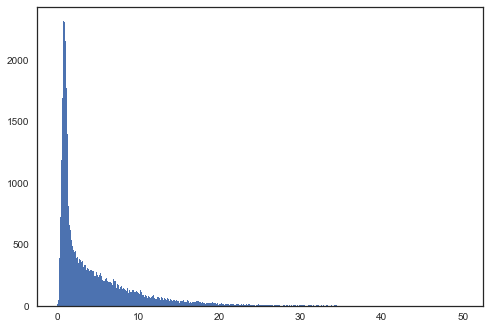

In [277]:
plt.hist(total_head_acc,bins=500,range=[0,50])

In [334]:
from scipy import interpolate

In [332]:
lfp_fs = 300.
lfp_time = np.arange(0,1354500/lfp_fs,1/lfp_fs) #np.linspace(0,lfp.shape[1]/lfp_fs,lfp.shape[1])

start_sec = 10 # + head_data.converted_times.iloc[0]
stop_sec = 4500 # + head_data.converted_times.iloc[0]


lfp_idx_start = np.where(lfp_time > start_sec )[0][0]
lfp_idx_stop = np.where(lfp_time < stop_sec )[0][-1]

truncated_lfp_time = lfp_time[lfp_idx_start-1:lfp_idx_stop+1]

In [ ]:
f_splrep_ax[0:5]

In [374]:
def get_interp_data(data,times_original,times_interp):

    f_splrep = interpolate.splrep(times_original,data)

    splrep = splev(times_interp, f_splrep)
    return splrep

In [375]:
splrep_ay = get_interp_data(head_data.ay.values,head_data.converted_times.values,truncated_lfp_time)

In [376]:
splrep_az = get_interp_data(head_data.az.values,head_data.converted_times.values,truncated_lfp_time)

splrep_ox = get_interp_data(head_data.ox.values,head_data.converted_times.values,truncated_lfp_time)
splrep_oy = get_interp_data(head_data.oy.values,head_data.converted_times.values,truncated_lfp_time)
splrep_oz = get_interp_data(head_data.oz.values,head_data.converted_times.values,truncated_lfp_time)


In [377]:
with open(os.getcwd() + '/interp_IMU_Oxyz_Axyz.pickle','wb') as f:
    pickle.dump([splrep_ox,splrep_oy,splrep_oz, splrep_ax,splrep_ay,splrep_az],f)

In [344]:
f_splrep_ax = interpolate.splrep(head_data.converted_times,head_data.ax.values)

splrep_ax = splev(truncated_lfp_time, f_splrep_ax)

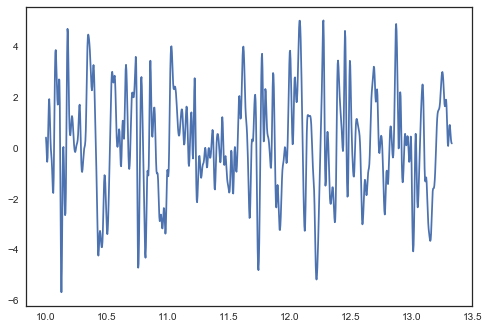

In [351]:
plt.plot(truncated_lfp_time[0:1000],splrep_ax[0:1000])

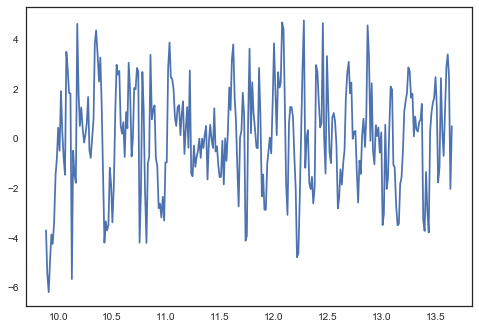

In [356]:
plt.plot(head_data.converted_times[150:450],head_data.ax[150:450])

In [357]:
f_splrep_ay = interpolate.splrep(head_data.converted_times,head_data.ay.values)

splrep_ay = splev(truncated_lfp_time, f_splrep_ay)

In [360]:
truncated_lfp_time[0:10]

array([ 10.        ,  10.00333333,  10.00666667,  10.01      ,
        10.01333333,  10.01666667,  10.02      ,  10.02333333,
        10.02666667,  10.03      ])

In [ ]:
######## to get angle of movement in x-y plane, get the sin of y/(root(y**2 + x**2))

In [358]:
xy_speed = np.sqrt(splrep_ay**2 + splrep_ax**2)

In [361]:
theta = np.rad2deg(np.arctan(splrep_ay / splrep_ax))

theta[ ~ np.isfinite( theta )] = 0

xy_speed = filter(xy_speed,[30] ,filt_type='lowpass',fs=300.)
theta = filter(theta,[30] ,filt_type='lowpass',fs=300.)

In [ ]:
xy_speed[5697:5700]

(array([  4.59798000e+05,   1.95492000e+05,   1.17174000e+05,
          9.39770000e+04,   7.99690000e+04,   6.86190000e+04,
          5.78000000e+04,   4.71690000e+04,   3.95600000e+04,
          3.23270000e+04,   2.65000000e+04,   2.18680000e+04,
          1.79420000e+04,   1.47040000e+04,   1.17410000e+04,
          9.75400000e+03,   7.61900000e+03,   6.50500000e+03,
          5.34900000e+03,   4.48300000e+03,   3.76700000e+03,
          3.13900000e+03,   2.66400000e+03,   2.29000000e+03,
          1.89000000e+03,   1.56200000e+03,   1.32100000e+03,
          1.04600000e+03,   9.15000000e+02,   8.00000000e+02,
          6.05000000e+02,   5.23000000e+02,   4.70000000e+02,
          3.81000000e+02,   2.90000000e+02,   2.65000000e+02,
          2.40000000e+02,   2.10000000e+02,   2.26000000e+02,
          1.79000000e+02,   1.63000000e+02,   1.35000000e+02,
          1.33000000e+02,   9.80000000e+01,   1.10000000e+02,
          1.05000000e+02,   9.40000000e+01,   7.60000000e+01,
        

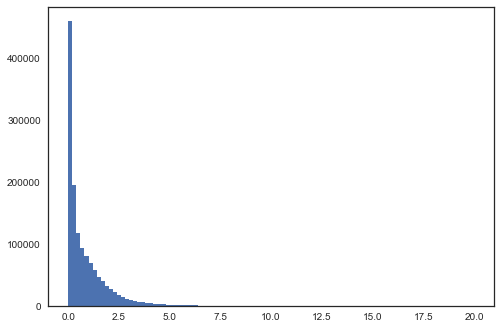

In [362]:
plt.hist(xy_speed,bins=100,range=[0,20])

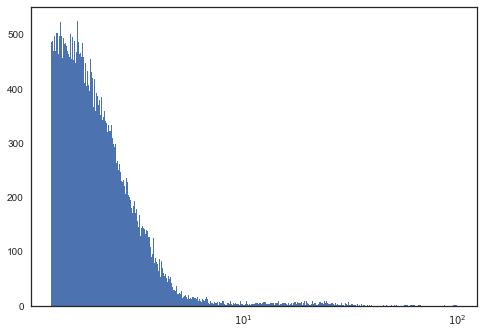

In [320]:
plt.hist(xy_speed,bins=np.logspace(.1,2,1000),range=[0,50])
plt.gca().set_xscale("log")

In [290]:
theta = np.rad2deg(np.arcsin(binned_ay / xy_speed))
theta[ ~ np.isfinite( theta )] = 0

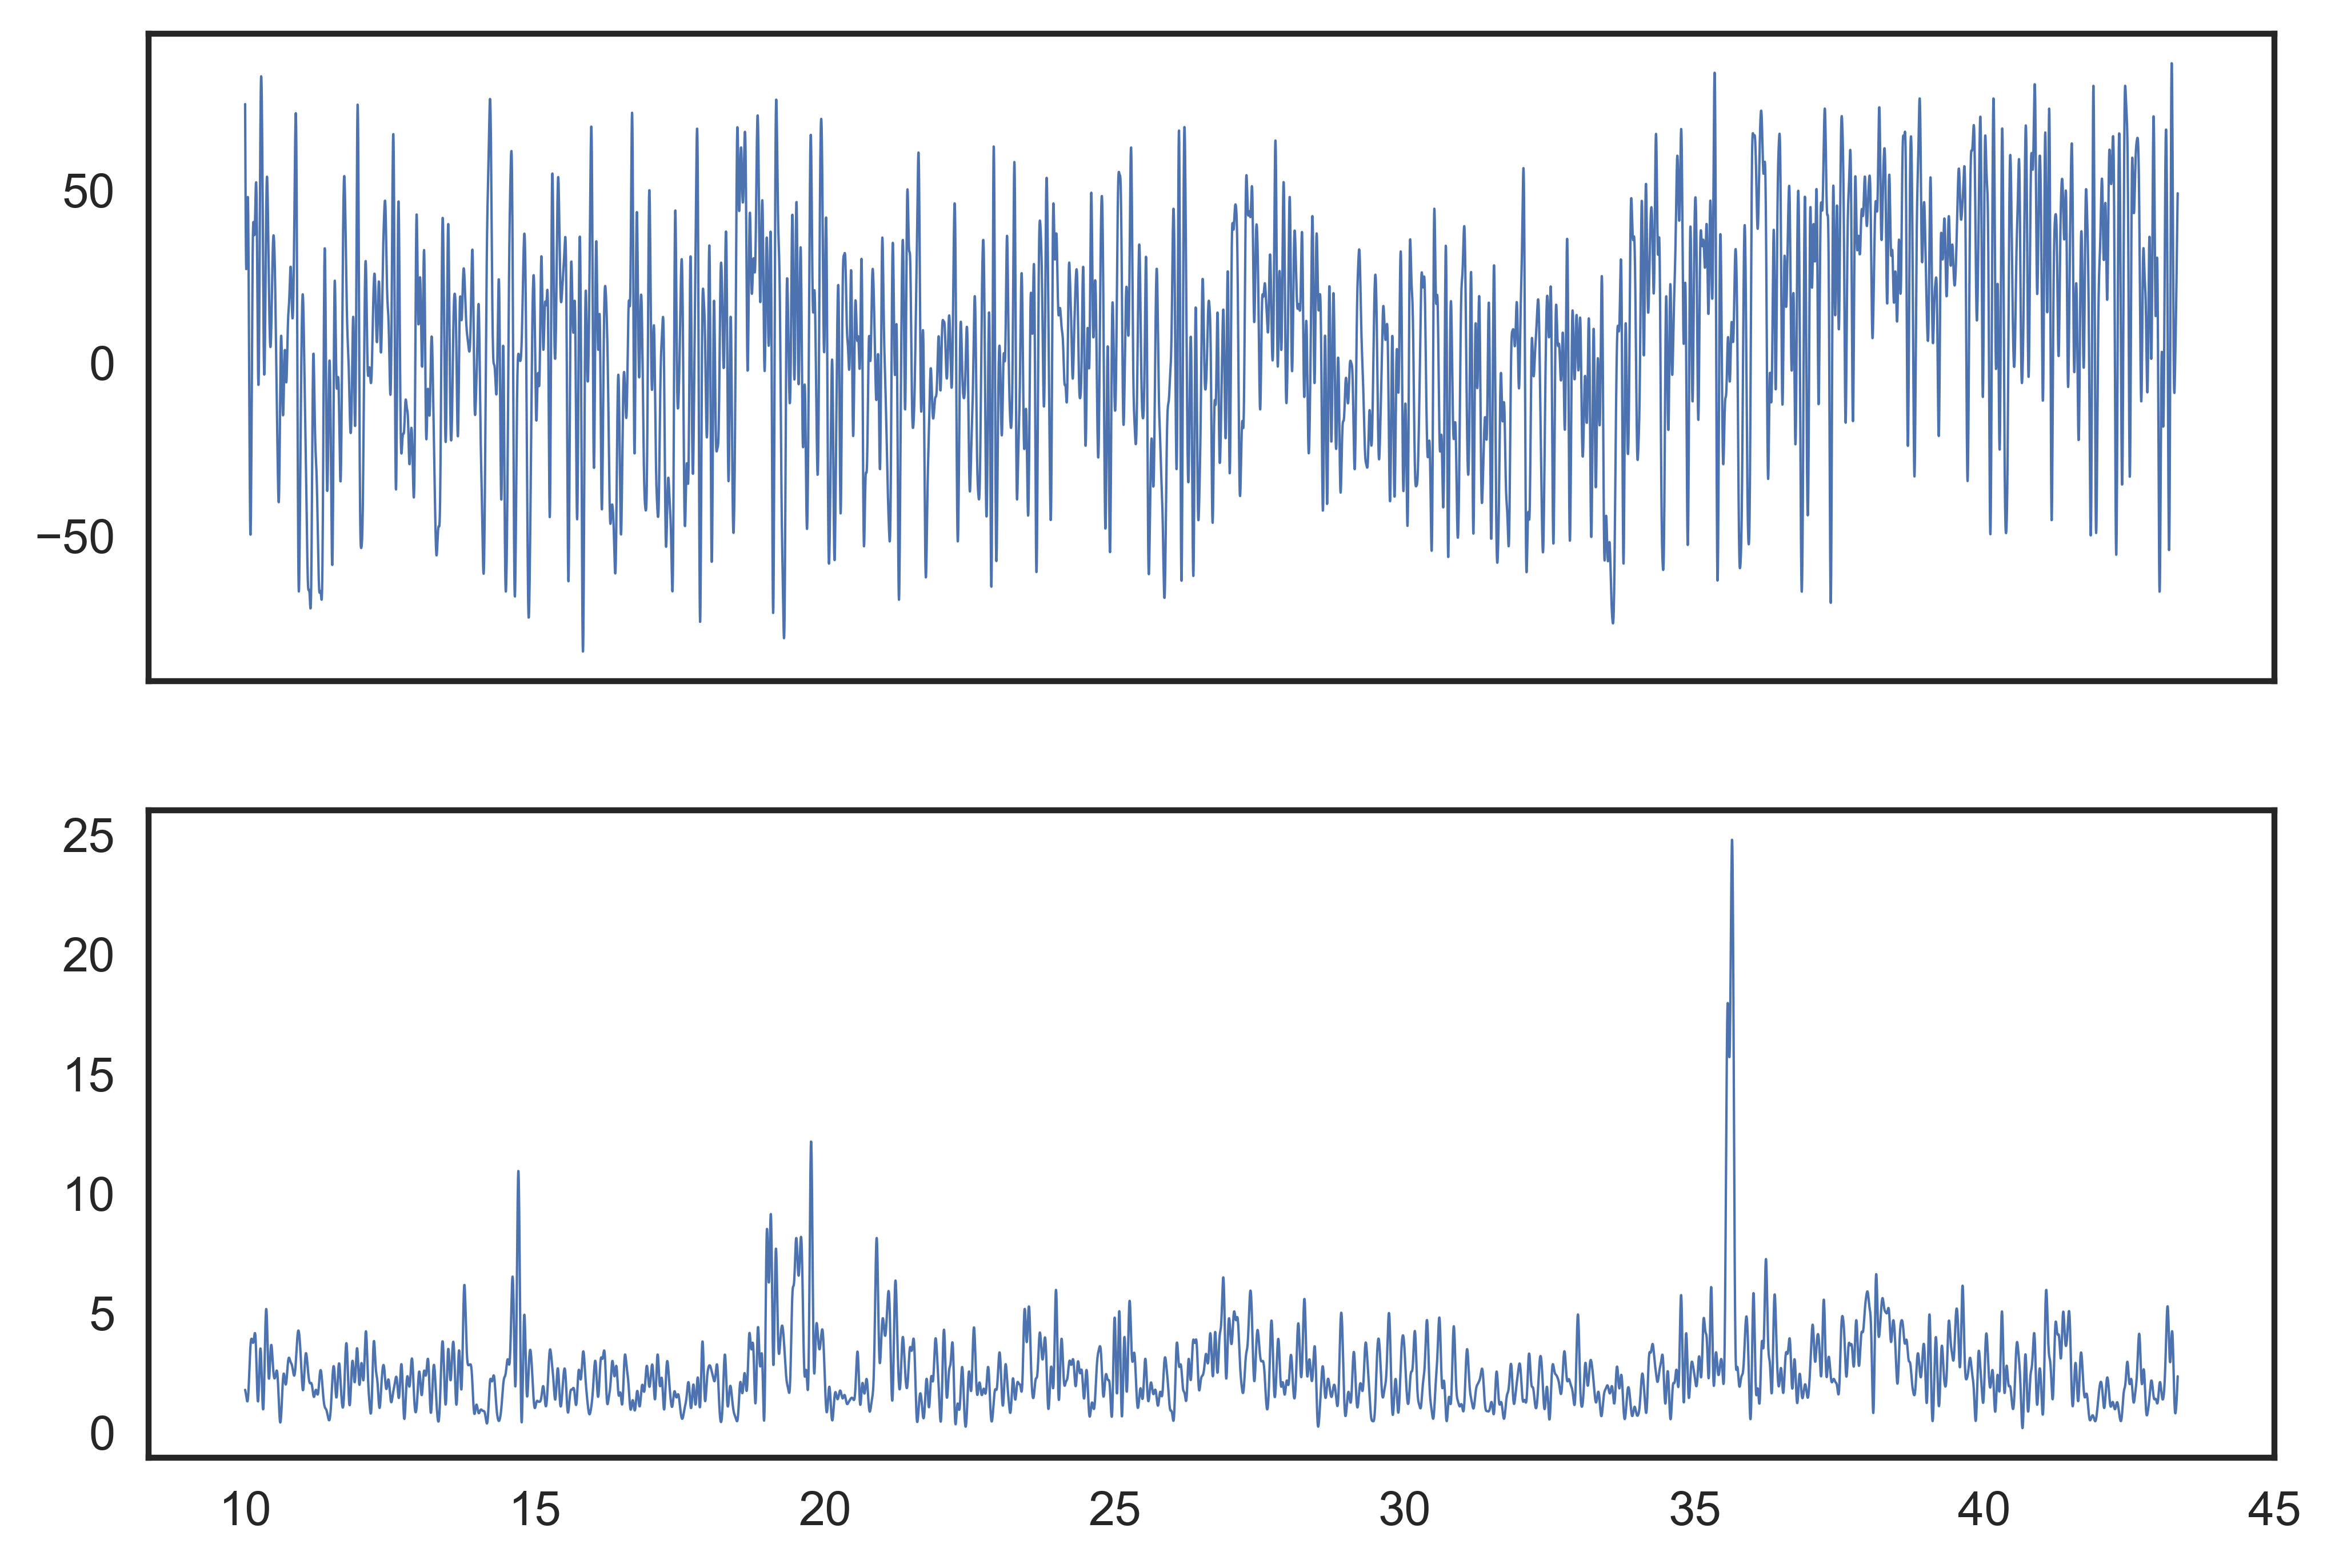

In [364]:
f, axarr = plt.subplots(2, sharex=True,dpi=600)



axarr[0].plot(truncated_lfp_time[0:10000],theta[0:10000],linewidth=.5)

axarr[1].plot(truncated_lfp_time[0:10000],xy_speed[0:10000],linewidth=.5)

In [ ]:
truncated_lfp_time.shape

In [369]:
truncated_lfp_time[0:10]

array([ 10.        ,  10.00333333,  10.00666667,  10.01      ,
        10.01333333,  10.01666667,  10.02      ,  10.02333333,
        10.02666667,  10.03      ])

(array([  2.00000000e+00,   5.00000000e+00,   1.60000000e+01,
          2.00000000e+01,   3.90000000e+01,   8.00000000e+01,
          1.07000000e+02,   2.00000000e+02,   3.10000000e+02,
          4.16000000e+02,   6.51000000e+02,   7.95000000e+02,
          1.15200000e+03,   1.58100000e+03,   1.80700000e+03,
          2.18900000e+03,   2.66800000e+03,   3.04100000e+03,
          3.53100000e+03,   3.77500000e+03,   4.13600000e+03,
          4.73800000e+03,   5.15400000e+03,   5.57500000e+03,
          5.95400000e+03,   6.46900000e+03,   7.18700000e+03,
          7.85300000e+03,   8.39000000e+03,   9.22700000e+03,
          1.00210000e+04,   1.06460000e+04,   1.17000000e+04,
          1.26510000e+04,   1.33850000e+04,   1.44210000e+04,
          1.54000000e+04,   1.62670000e+04,   1.73480000e+04,
          1.89610000e+04,   2.04640000e+04,   2.16120000e+04,
          2.28100000e+04,   2.43650000e+04,   2.58970000e+04,
          2.76450000e+04,   2.95410000e+04,   3.13250000e+04,
        

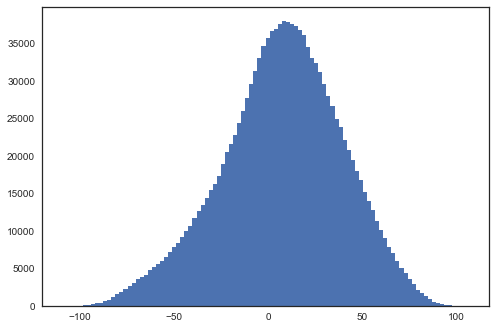

In [365]:
plt.hist(theta,bins=100)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([ -11.23721981,   -9.97047973,   -8.70373965,   -7.43699957,
          -6.17025949,   -4.90351941,   -3.63677933,   -2.37003925,
          -1.10329917,    0.16344091,    1.430181  ,    2.69692108,
           3.96366116,    5.23040124,    6.49714132,    7.7638814 ,
           9.03062148,   10.29736156,   11.56410164,   12.83084172,
          14.09758181,   15.36432189,   16.63106197,   17.89780205,
          19.16454213,   20.43128221,   21.69802229,   22.96476237,
          24.23150245,   25.49824253,   26.76498262,   28.0317227 ,
          29.29846278,   30.56520286,   31.83194294,   33.09868302,
          34.3654231 ,   35.63216318,   36.89890326,   38.16564334,
          39.43238343,   40.699123

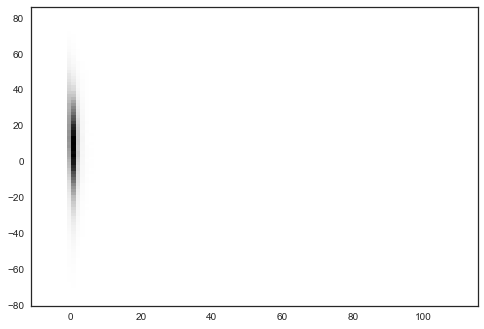

In [324]:
plt.hist2d(xy_speed,theta,bins=100)

In [313]:
np.rad2deg((np.arcsin(1)))

90.0

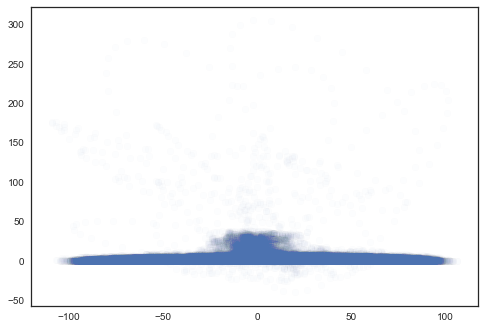

In [366]:
plt.scatter(theta, xy_speed,alpha=.01)

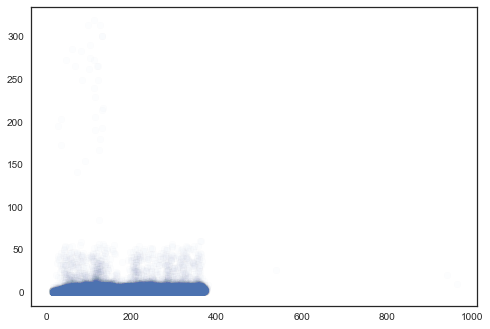

In [259]:
plt.scatter(total_head_angle,total_head_acc,alpha=.01)

In [367]:
with open(os.getcwd() + '/theta_xyspeed.pickle','wb') as f:
    pickle.dump([theta,xy_speed],f)

In [330]:
theta.shape

(358506,)